<a href="https://colab.research.google.com/github/mvm1964/MGVB/blob/main/TP53_ANN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(f"Using {device} device")

Using cuda device


In [21]:
# prompt: create a torch neural net class with two hided layers and a single continuous node in the output layer

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, 1) # Single continuous output node
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


In [3]:
# prompt: create pandas dataframe with 20 continuous columns and 1000 rows filled with random numbers from 0 to 1

import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

# Create a DataFrame with 20 continuous columns and 1000 rows
#data = np.random.rand(1000, 20)
#df = pd.DataFrame(data)

df = pd.read_csv('/content/drive/My Drive/CUDA/data_for_GP.csv')
df = pd.get_dummies(df.drop('barcode', axis=1), dtype=int)
df


Mounted at /content/drive


,TERT_expression,TP53_expression,AURKB_expression,MCM7_expression,CDT1_expression,WDR62_expression,DDX12P_expression,FANCA_expression,CCPG1_expression,ELAC2_expression,Subtype,chr17p_loss,TP53_genotype_missense,TP53_genotype_trunc,TP53_genotype_wt,PIK3CA_genotype_mutant,PIK3CA_genotype_wt
0,2.777472,12.113931,6.294367,11.817677,8.109863,6.443701,6.031697,7.773672,10.483088,10.667074,1,0,0,0,1,0,1
1,0.410450,10.480347,6.695908,11.070551,7.688933,7.791068,5.303879,6.668072,11.095231,9.825949,0,1,0,0,1,0,1
2,1.999567,10.761224,6.661727,11.215446,8.339923,7.708767,6.364515,7.044879,10.342294,10.209237,0,1,0,0,1,0,1
3,1.286881,10.662042,6.252491,10.256026,7.004965,7.602305,4.965336,6.107719,10.948345,10.531630,0,0,0,0,1,0,1
4,0.000000,10.263598,5.227910,10.007178,6.004540,6.106363,4.634367,6.050151,11.748417,9.771334,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,1.233888,10.659143,6.770258,11.099064,7.079962,8.074620,6.294849,6.928022,11.168627,10.647435,0,0,0,0,1,0,1
663,0.500292,10.790157,6.506826,10.837435,6.614486,6.632678,5.952480,6.452694,10.941214,10.722052,0,0,0,0,1,0,1
664,2.516393,10.570715,8.942631,11.495017,8.691711,9.215838,8.189915,7.752747,10.763663,10.033867,0,1,0,0,1,0,1
665,2.452385,10.653153,7.409273,11.078412,8.407137,8.097310,7.736244,7.926747,9.833109,10.054099,0,1,0,0,1,1,0


In [34]:
model = NeuralNetwork(input_size=14, hidden_size1=64, hidden_size2=32).to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=14, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [35]:
# Read data, convert to NumPy arrays
X = df.iloc[:, 3:17].values
y = df.iloc[:, 2].values

#device = torch.device("cpu")

# convert into PyTorch tensors
X = torch.tensor(X, dtype=torch.float32, device=device)
y = torch.tensor(y, dtype=torch.float32, device=device).reshape(-1, 1)

# create DataLoader, then take one batch
#loader = DataLoader(list(zip(X,y)), shuffle=True, batch_size=8)



In [36]:
import torch.optim as optim
from sklearn.model_selection import train_test_split
# train-test split for evaluation of the model
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=123)

# set up DataLoader for training set
loader = DataLoader(list(zip(X_train, y_train)), shuffle=True, batch_size=16)


In [37]:
# train
n_epochs = 300
loss_fn = nn.MSELoss()
#optimizer = optim.SGD(model.parameters(), lr=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
model.train()
for epoch in range(n_epochs):
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# evaluate accuracy after training
model.eval()
y_pred = model(X_test)



In [38]:
from sklearn.metrics import r2_score
y_t = y_test.cpu()
y_p = y_pred.cpu()
r2 = r2_score(y_t.detach().numpy(), y_p.detach().numpy())
print("R^2 score: %.2f" % r2)

#acc = (y_pred.round() == y_test).float().mean()
#acc = float(acc)
#print("Model accuracy: %.2f%%" % (acc*100))

R^2 score: 0.76


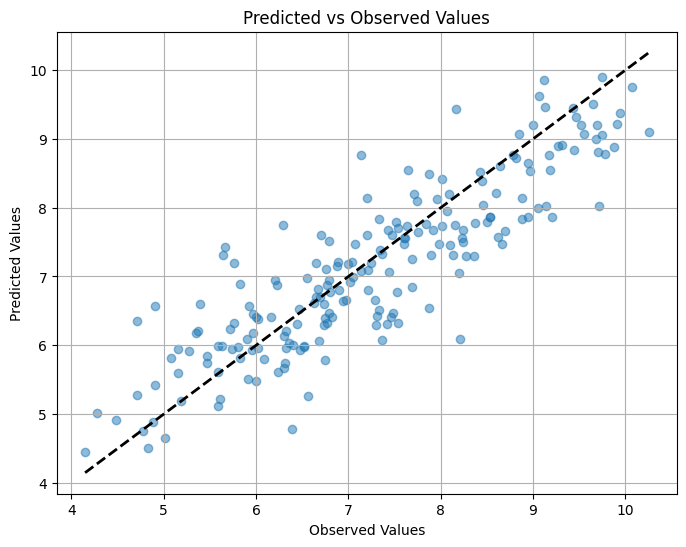

In [39]:
# prompt: plot predicted versus observed values of the above ANN model and save the plot to png file on Drive

import matplotlib.pyplot as plt

# Assuming y_t and y_p are already defined from the previous code
plt.figure(figsize=(8, 6))
plt.scatter(y_t.detach().numpy(), y_p.detach().numpy(), alpha=0.5)
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Observed Values')
plt.plot([y_t.min(), y_t.max()], [y_t.min(), y_t.max()], 'k--', lw=2) # Add a diagonal line
plt.grid(True)

# Save the plot to Google Drive
plt.savefig('/content/drive/My Drive/CUDA/predicted_vs_observed.png')

plt.show()


In [41]:
# prompt: implement k-fold cross-validation of model

import numpy as np
from sklearn.model_selection import KFold

# ... (Your existing code) ...

# Define the number of folds for cross-validation
n_splits = 5  # Example: 5-fold cross-validation
n_epochs = 120
# Initialize KFold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42) # Setting random_state for reproducibility

# Lists to store results for each fold
r2_scores = []

# Iterate through each fold
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {fold + 1}")

    # Split the data into training and testing sets for the current fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create DataLoader for the current fold's training set
    loader = DataLoader(list(zip(X_train, y_train)), shuffle=True, batch_size=16)

    # Initialize the model for each fold
    model = NeuralNetwork(input_size=14, hidden_size1=64, hidden_size2=44).to(device)

    # Set up the optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=12.5e-4, weight_decay=6.25e-4, betas=[0.9, 0.999], amsgrad=True)
    loss_fn = nn.MSELoss()

    # Train the model for the current fold
    model.train()
    for epoch in range(n_epochs):
      for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate the model for the current fold
    model.eval()
    y_pred = model(X_test)
    y_t = y_test.cpu()
    y_p = y_pred.cpu()
    r2 = r2_score(y_t.detach().numpy(), y_p.detach().numpy())
    r2_scores.append(r2)

    print(f"R^2 score for fold {fold + 1}: {r2:.2f}")

# Calculate and print the average R^2 score across all folds
avg_r2 = np.mean(r2_scores)
print(f"\nAverage R^2 score across all folds: {avg_r2:.2f}")


Fold 1
R^2 score for fold 1: 0.75
Fold 2
R^2 score for fold 2: 0.79
Fold 3
R^2 score for fold 3: 0.80
Fold 4
R^2 score for fold 4: 0.74
Fold 5
R^2 score for fold 5: 0.82

Average R^2 score across all folds: 0.78


In [17]:
x = [1,2,3]
y = [4]


In [20]:
np.abs(np.array(y) - np.array(x))

array([3, 2, 1])